# Echo State Network as a tunable frequency generator

This is a simplified implementation of Herbert Jaeger's task of learning a simple non-autonomous system, [a frequency generator controlled by an external signal](http://www.scholarpedia.org/article/Echo_state_network). Plots at the end.

[See the ESN implementation](https://github.com/cknd/pyESN).


In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pyESN import ESN
from sklearn.model_selection import train_test_split
from Loader import Loader

In [2]:
random_state = 42

In [4]:
import torch as t

In [5]:
t

<module 'torch' from '/home/kerwick.a/KFold_Neural_Operator/.pytorch_venv/lib/python3.9/site-packages/torch/__init__.py'>

## Task

The network will learn to generate a wave signal whose frequency is determined by some slowly changing control input.

#### 1) Generate some sample data:


In [8]:
threshold = 1000
def get_mask(u, y):
    u_tensor = torch.tensor(u)
    y_tensor = torch.tensor(y)

    # Identify indices with NaNs
    nan_mask = torch.isnan(u_tensor).any(dim=(1, 2)) | torch.isnan(y_tensor).any(dim=(1, 2))
    nan_samples_count = nan_mask.sum().item()

    # Identify indices where max y exceeds threshold
    max_y_values = y_tensor.max(dim=2).values.max(dim=1).values
    threshold_mask = max_y_values <= threshold
    large_samples_count = (~threshold_mask).sum().item()

    # Combine masks
    valid_mask = ~nan_mask & threshold_mask
    return valid_mask, nan_samples_count, large_samples_count

In [25]:
datapath = '../NIEMRE_Feb20_2025/Hodgkin_Huxley/data/'
loader = Loader()
loader.mount(datapath)
A_list = [i for i in range(20, 150, 30)]
fc_list = [i for i in range(10, 1100, 100)]
fm_list = [i for i in range(10, 61, 10)]
data = loader.load_db(
            A_list=A_list,
            fc_list=fc_list,
            fm_list=fm_list
        )
u, y = data[0], data[1]

total_samples = u.shape[0]
mask, nan_samples_count, large_samples_count = get_mask(u, y)

print(f'Total samples before filtering: {total_samples}')
print(f'Samples containing NaN: {nan_samples_count}')
print(f'Samples exceeding threshold {threshold}: {large_samples_count}')

# Apply mask
u, y = u[mask.numpy()], y[mask.numpy()]

# Recalculate after filtering
total_samples_after = u.shape[0]

print(f'Total samples after filtering: {total_samples_after}')

Loader successfully mounted to the directory: ../NIEMRE_Feb20_2025/Hodgkin_Huxley/data/
Metadata successfully mounted to: ../NIEMRE_Feb20_2025/Hodgkin_Huxley/data/metadata
Total samples before filtering: 330
Samples containing NaN: 0
Samples exceeding threshold 1000: 0
Total samples after filtering: 330


In [26]:
u.shape

(330, 4, 5000)

In [27]:
u = u[0].T
y = y[0].T

In [28]:
u.shape

(5000, 4)

In [29]:
u_train = u[:4000]
u_test = u[4000:]
y_train = y[:4000]
y_test = y[4000:]

In [10]:
u_train,u_test, y_train, y_test = train_test_split(
    u, y, test_size=0.3, random_state=random_state)

In [ ]:
rng = np.random.RandomState(42)
def frequency_generator(N,min_period,max_period,n_changepoints):
    """returns a random step function with N changepoints
       and a sine wave signal that changes its frequency at
       each such step, in the limits given by min_ and max_period."""
    # vector of random indices < N, padded with 0 and N at the ends:
    changepoints = np.insert(np.sort(rng.randint(0,N,n_changepoints)),[0,n_changepoints],[0,N])
    # list of interval boundaries between which the control sequence should be constant:
    const_intervals = list(zip(changepoints,np.roll(changepoints,-1)))[:-1]
    # populate a control sequence
    frequency_control = np.zeros((N,1))
    for (t0,t1) in const_intervals:
        frequency_control[t0:t1] = rng.rand()
    periods = frequency_control * (max_period - min_period) + max_period
    # run time through a sine, while changing the period length
    frequency_output = np.zeros((N,1))
    z = 0
    for i in range(N):
        z = z + 2 * np.pi / periods[i]
        frequency_output[i] = (np.sin(z) + 1)/2
    return np.hstack([np.ones((N,1)),1-frequency_control]),frequency_output


N = 15000 # signal length
min_period = 2
max_period = 10
n_changepoints = int(N/200)
frequency_control,frequency_output = frequency_generator(N,min_period,max_period,n_changepoints)

traintest_cutoff = int(np.ceil(0.7*N))

train_ctrl,train_output = frequency_control[:traintest_cutoff],frequency_output[:traintest_cutoff]
test_ctrl, test_output  = frequency_control[traintest_cutoff:],frequency_output[traintest_cutoff:]

#### 2) Instantiate, train & test the network
Parameters are mostly the same as in Herbert Jaeger's original Matlab code. 

In [30]:
u_train.shape

(4000, 4)

In [14]:
u_train.shape[1:]

(4, 5000)

In [32]:
esn = ESN(n_inputs = u.shape[1],
          n_outputs = y.shape[1],
          n_reservoir = 200,
          spectral_radius = 0.25,
          sparsity = 0.95,
          noise = 0.001,
#           input_shift = [0,0],
#           input_scaling = [0.01, 3],
#           teacher_scaling = 1.12,
#           teacher_shift = -0.7,
          #out_activation = np.tanh,
          #inverse_out_activation = np.arctanh,
          random_state = random_state,
          silent = False)

pred_train = esn.fit(u_train,y_train)

print("test error:")
pred_test = esn.predict(u_test)
print(np.sqrt(np.mean((pred_test - y_test)**2)))

harvesting states...
fitting...
training error:
1.0007063981488165
test error:
402.6350805767292


#### 3) Plots
First, a look at the control signal, the target signal and the output of the model both during training and during testing.

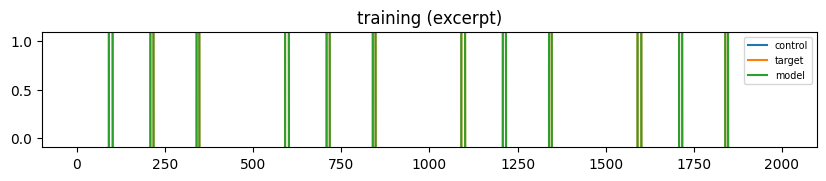

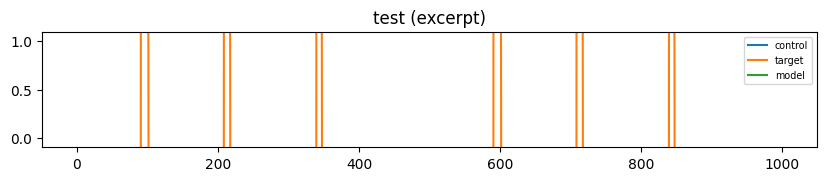

In [35]:
window_tr = range(int(len(y_train)/4),int(len(y_train)/4+2000))
plt.figure(figsize=(10,1.5))
plt.plot(u_train[window_tr,1],label='control')
plt.plot(y_train[window_tr],label='target')
plt.plot(pred_train[window_tr],label='model')
plt.legend(fontsize='x-small')
plt.title('training (excerpt)')
plt.ylim([-0.1,1.1])
plt.show()

window_test = range(1000)
plt.figure(figsize=(10,1.5))
plt.plot(u_test[window_test,1],label='control')
plt.plot(y_test[window_test],label='target')
plt.plot(pred_test[window_test],label='model')
plt.legend(fontsize='x-small')
plt.title('test (excerpt)')
plt.ylim([-0.1,1.1]);
plt.show()

In [ ]:
window_tr = range(int(len(train_output)/4),int(len(train_output)/4+2000))
plt.figure(figsize=(10,1.5))
plt.plot(train_ctrl[window_tr,1],label='control')
plt.plot(train_output[window_tr],label='target')
plt.plot(pred_train[window_tr],label='model')
plt.legend(fontsize='x-small')
plt.title('training (excerpt)')
plt.ylim([-0.1,1.1])
plt.show()

window_test = range(2000)
plt.figure(figsize=(10,1.5))
plt.plot(test_ctrl[window_test,1],label='control')
plt.plot(test_output[window_test],label='target')
plt.plot(pred_test[window_test],label='model')
plt.legend(fontsize='x-small')
plt.title('test (excerpt)')
plt.ylim([-0.1,1.1]);
plt.show()

What we see is that we can't see much, except that the amplitude is systematically too small (any ideas why that is?).

So let's look at a few spectrograms to see how the frequency spectrum of these signals changes over time.

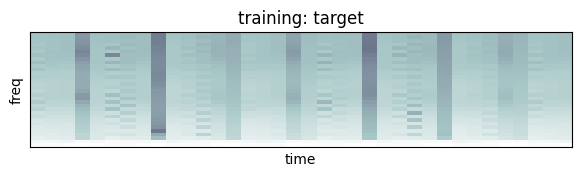

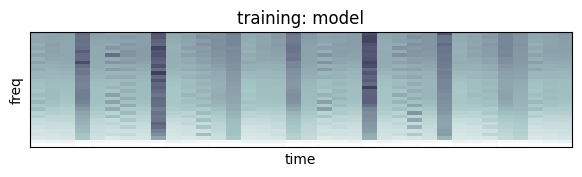

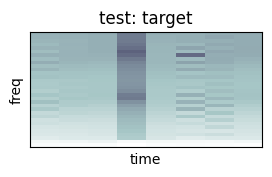

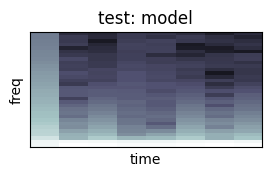

In [36]:
def draw_spectogram(data):
    plt.specgram(data,Fs=4,NFFT=256,noverlap=150,cmap=plt.cm.bone,detrend=lambda x:(x-0.5))
    plt.gca().autoscale('x')
    plt.ylim([0,0.5])
    plt.ylabel("freq")
    plt.yticks([])
    plt.xlabel("time")
    plt.xticks([])

plt.figure(figsize=(7,1.5))
draw_spectogram(y_train.flatten())
plt.title("training: target")
plt.show()
plt.figure(figsize=(7,1.5))
draw_spectogram(pred_train.flatten())
plt.title("training: model")
plt.show()

plt.figure(figsize=(3,1.5))
draw_spectogram(y_test.flatten())
plt.title("test: target")
plt.show()
plt.figure(figsize=(3,1.5))
draw_spectogram(pred_test.flatten())
plt.title("test: model")
plt.show()

It's a frequency generator!